#### Importing Relevant Libraries

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup
#import geocoders
import os

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

#### Get the New York Neighborhood Data in a dataframe: ny_data ####

In [2]:
import json
url = 'https://cocl.us/new_york_dataset'
resp=requests.get(url).json()
# all data is present in features label
features=resp['features']
    
    # define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
ny_data = pd.DataFrame(columns=column_names)
    
for data in features:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_data = ny_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [3]:
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
ny_data.shape

(306, 4)

#### Plot Number of Neighbourhoods for each Borough

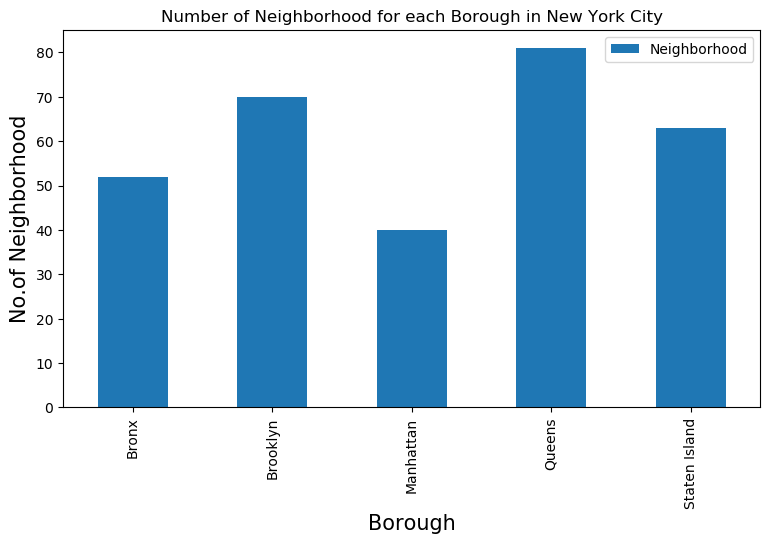

In [5]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
ny_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### Credentials for connection to Foursquare API

In [5]:
CLIENT_ID = '4SGFPSLNWMK1QLQOTDG3UVYXV423ODFIBYV1M4VQVSVFKDAG' # your Foursquare ID
CLIENT_SECRET = 'HK0TENVSSGZX3DAFRHRO55SDHLDBBNDRBL5NCZWYBYJE5XVH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 4SGFPSLNWMK1QLQOTDG3UVYXV423ODFIBYV1M4VQVSVFKDAG
CLIENT_SECRET:HK0TENVSSGZX3DAFRHRO55SDHLDBBNDRBL5NCZWYBYJE5XVH


###### Define Function to Get Venues

In [6]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [7]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]["groups"][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

##### Define Function to get venue details

In [8]:
def get_venue_details(venue_id):
        
  
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

##### Explore the different types of cuisines/Restaurants in New York

In [13]:
count=1
categories_list = []
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    count+=1
    print(count)
    categories_list.append(venues['Category'])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [14]:
categories_series = pd.Series(categories_list)

In [15]:
m=[ ]
for x in categories_list:
    for y in x:
        m.append(y)

In [16]:
import collections
counter=collections.Counter(m)
print(counter.most_common(20))

[('Pizza Place', 1015), ('Italian Restaurant', 552), ('Coffee Shop', 535), ('Deli / Bodega', 474), ('Donut Shop', 460), ('Bakery', 447), ('Sandwich Place', 433), ('Chinese Restaurant', 421), ('Bar', 414), ('Park', 413), ('Pharmacy', 395), ('Grocery Store', 359), ('Mexican Restaurant', 329), ('Bank', 326), ('Ice Cream Shop', 325), ('Café', 322), ('American Restaurant', 319), ('Supermarket', 298), ('Fast Food Restaurant', 277), ('Gym / Fitness Center', 250)]


##### Chinese Restaurants to be further explored 

In [10]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Restaurant in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Restaurant in Wakefield, Bronx:2
( 2 / 306 ) Chinese Restaurant in Co-op City, Bronx:2
( 3 / 306 ) Chinese Restaurant in Eastchester, Bronx:1
( 4 / 306 ) Chinese Restaurant in Fieldston, Bronx:1
( 5 / 306 ) Chinese Restaurant in Riverdale, Bronx:0
( 6 / 306 ) Chinese Restaurant in Kingsbridge, Bronx:0
( 7 / 306 ) Chinese Restaurant in Marble Hill, Manhattan:0
( 8 / 306 ) Chinese Restaurant in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Restaurant in Norwood, Bronx:4
( 10 / 306 ) Chinese Restaurant in Williamsbridge, Bronx:0
( 11 / 306 ) Chinese Restaurant in Baychester, Bronx:4
( 12 / 306 ) Chinese Restaurant in Pelham Parkway, Bronx:4
( 13 / 306 ) Chinese Restaurant in City Island, Bronx:1
( 14 / 306 ) Chinese Restaurant in Bedford Park, Bronx:3
( 15 / 306 ) Chinese Restaurant in University Heights, Bronx:1
( 16 / 306 ) Chinese Restaurant in Morris Heights, Bronx:4
( 17 / 306 ) Chinese Restaurant in Fordham, Bronx:1
( 18 / 306 ) Chinese Restaurant in East Tremont, Bronx:

In [11]:
chinese_rest_ny.shape

(414, 4)

###### In order to save time, I have saved the data on Borough, Neighborhood, ID and Name corresponding to Chinese Restaurants in a csv file

In [12]:
from project_lib import Project
project = Project(None,"17070c1a-76d2-4995-8fad-a3b4e812b548","p-081fa8cfff5e0c9c944049dbc6440f23cd9a4aff")
project.save_data(data=chinese_rest_ny.to_csv(index=False),file_name='chinese_rest_ny.csv',overwrite=True)

{'file_name': 'chinese_rest_ny.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'example-donotdelete-pr-9tdgdg4ochidit',
 'asset_id': 'cbeecc64-3a4f-49b7-99f7-d8b47d916135'}

###### The saved data on details on Chinese restaurants basis the borough & neighborhoods can be imported from the csv file that was saved

In [9]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_c811c76ae9174522a71b456954cc479a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='HpCPUzdj2DBXZBGoiao3-FzmGuTBlvrKcNhrOcJyK1O0',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_c811c76ae9174522a71b456954cc479a.get_object(Bucket='example-donotdelete-pr-9tdgdg4ochidit',Key='chinese_rest_ny.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

chinese_rest_ny = pd.read_csv(body)
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Wakefield,4c3de66616ca95215b17bc7f,Dragon Star Chinese Food
2,Bronx,Co-op City,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant
3,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
4,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant


##### Number of Chinese Restaurants for Each Borough

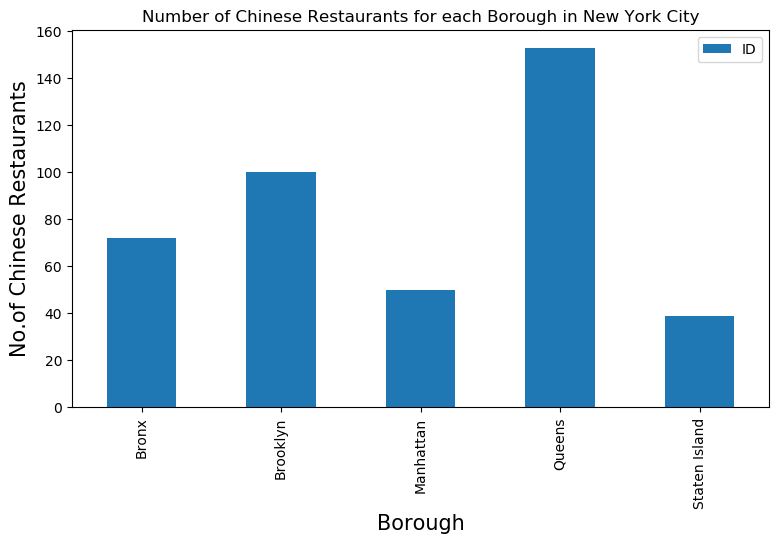

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Restaurants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

##### Number of Chinese Restaurants by Neighborhood

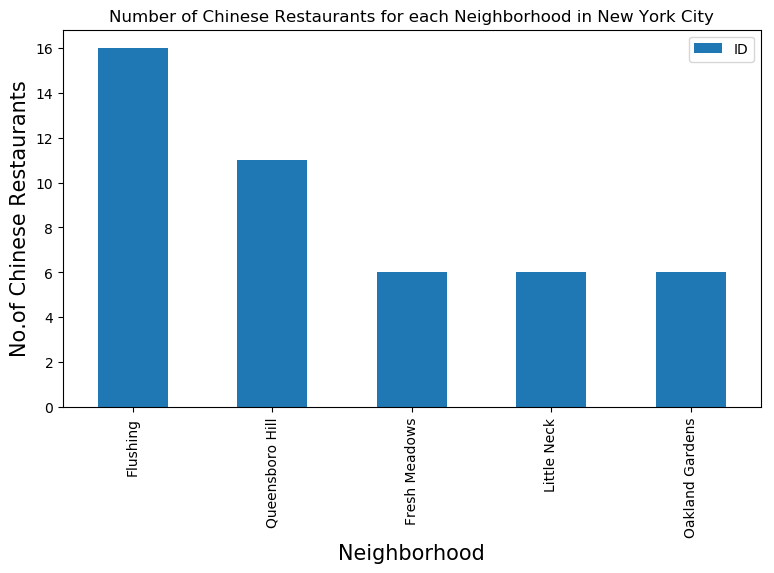

In [36]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Restaurants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [12]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Flushing']

,Borough,Neighborhood,ID,Name
189,Queens,Flushing,5747a89b498ee4b7a5106556,DunHuang Lanzhou Beef Noodle
190,Queens,Flushing,52235ea211d2fe55782d764c,Dong Yi Feng
191,Queens,Flushing,4abfef82f964a520179320e3,New Imperial Palace 東湖
192,Queens,Flushing,4ad50f59f964a520950121e3,Fu Run 賦潤東北美食
193,Queens,Flushing,4fa3f81be4b0a34ac673bf1e,Taipei Hong 台北夯
194,Queens,Flushing,4a1845c8f964a52092791fe3,Asian Jewels Seafood Restaurant 敦城海鲜酒家
195,Queens,Flushing,4faff7eae4b03b8055801cde,Xi'an Famous Foods
196,Queens,Flushing,4ef37491d3e32dc398c7c5c7,Laoma Mala Tang
197,Queens,Flushing,4c78756397028cfaec16d8fe,New Golden Szechuan Chinese Restaurant
198,Queens,Flushing,5990ab0a826444188d18dabc,Szechuan House


##### 16 Chinese Restaurants in Flushing: Exploring Details on the Chinese Restaurants

In [16]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
( 1 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c3de66616ca95215b17bc7f
( 2 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c9d5f2654c8a1cd2e71834b
( 3 / 414 ) processed
                         ID            Name  Likes  Rating  Tips
0  4c66dcfaaebea593955a74d0  Chinese Buffet      7     4.9    10
( 4 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4dabc3dc93a04642f09ccabd
( 5 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4f5543a7e4b0ac8e5378b9de
( 6 / 414 ) processed
                         ID                            Name  Likes  Rating  \
0  4e2e08021838f1c552b6b8eb  Choi Yuan - Chinese Restaurant      6    

In [17]:
chinese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0,0,0
1,Bronx,Wakefield,0,0,0,0,0
2,Bronx,Co-op City,0,0,0,0,0
3,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,7,4.9,10
4,Bronx,Eastchester,0,0,0,0,0


###### Due to the limits of calls, we can save the venue details data in a csv file for use later

In [18]:
from project_lib import Project
project = Project(None,"17070c1a-76d2-4995-8fad-a3b4e812b548","p-081fa8cfff5e0c9c944049dbc6440f23cd9a4aff")
project.save_data(data=chinese_rest_stats_ny.to_csv(index=False),file_name='chinese_rest_stats_ny.csv',overwrite=True)

{'file_name': 'chinese_rest_stats_ny.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'example-donotdelete-pr-9tdgdg4ochidit',
 'asset_id': '6fed56e6-3d67-4ad6-b4dd-a9f3837774da'}

In [19]:
chinese_rest_stats_ny.shape

(414, 7)

In [13]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_c811c76ae9174522a71b456954cc479a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='HpCPUzdj2DBXZBGoiao3-FzmGuTBlvrKcNhrOcJyK1O0',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_c811c76ae9174522a71b456954cc479a.get_object(Bucket='example-donotdelete-pr-9tdgdg4ochidit',Key='chinese_rest_stats_ny.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

chinese_rest_stats_ny = pd.read_csv(body)
chinese_rest_stats_ny.head()


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0,0.0,0
1,Bronx,Wakefield,0,0,0,0.0,0
2,Bronx,Co-op City,0,0,0,0.0,0
3,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,7,4.9,10
4,Bronx,Eastchester,0,0,0,0.0,0


In [14]:
chinese_rest_stats_ny.shape

(414, 7)

In [15]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
Borough         414 non-null object
Neighborhood    414 non-null object
ID              414 non-null object
Name            414 non-null object
Likes           414 non-null int64
Rating          414 non-null float64
Tips            414 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 22.7+ KB


In [16]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')


In [17]:
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')

In [18]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1472
Rating                               9.2
Tips                                 520
Name: 158, dtype: object

In [19]:
# Resturant with maximum Rating
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1472
Rating                               9.2
Tips                                 520
Name: 158, dtype: object

In [20]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1472
Rating                               9.2
Tips                                 520
Name: 158, dtype: object

In [21]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [22]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(15)

,Neighborhood,Average Rating
29,Chelsea,9.20
66,Flatiron,9.20
83,Greenpoint,9.10
133,Noho,9.00
135,North Side,9.00
129,Murray Hill,9.00
121,Midtown South,9.00
77,Gramercy,9.00
165,South Side,9.00
187,West Village,8.95


In [23]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [24]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.356000
3,Queens,4.647712
1,Brooklyn,4.524000
4,Staten Island,3.884615
0,Bronx,2.104167


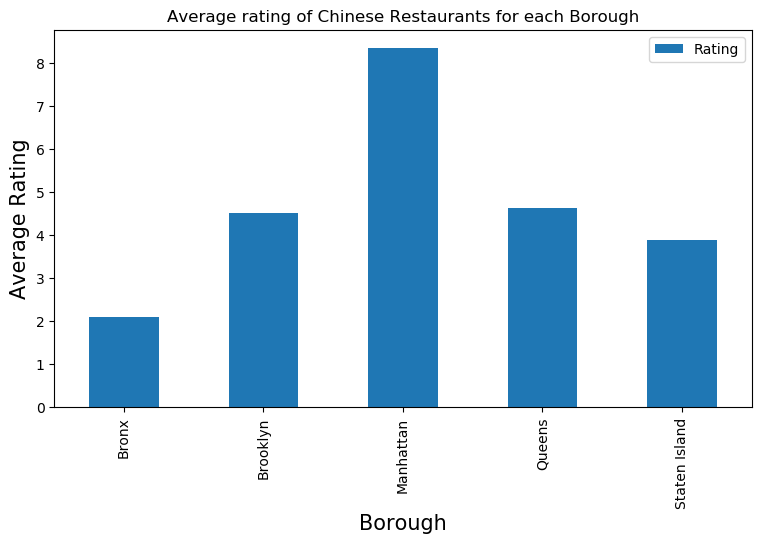

In [25]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Restaurants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [26]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [27]:
ny_neighborhood_stats

,Neighborhood,Average Rating
29,Chelsea,9.2
66,Flatiron,9.2
77,Gramercy,9.0
83,Greenpoint,9.1
121,Midtown South,9.0
129,Murray Hill,9.0
133,Noho,9.0
135,North Side,9.0
165,South Side,9.0


In [28]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')

In [29]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [30]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,9.2
1,Staten Island,Chelsea,40.594726,-74.189560,9.2
2,Manhattan,Flatiron,40.739673,-73.990947,9.2
3,Manhattan,Gramercy,40.737210,-73.981376,9.0
4,Brooklyn,Greenpoint,40.730201,-73.954241,9.1
5,Manhattan,Midtown South,40.748510,-73.988713,9.0
6,Manhattan,Murray Hill,40.748303,-73.978332,9.0
7,Queens,Murray Hill,40.764126,-73.812763,9.0
8,Manhattan,Noho,40.723259,-73.988434,9.0
9,Brooklyn,North Side,40.714823,-73.958809,9.0


In [31]:
## Data on Map

In [32]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=10)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [33]:
ny_neighborhood_stats.head()

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,9.2
1,Staten Island,Chelsea,40.594726,-74.189560,9.2
2,Manhattan,Flatiron,40.739673,-73.990947,9.2
3,Manhattan,Gramercy,40.737210,-73.981376,9.0
4,Brooklyn,Greenpoint,40.730201,-73.954241,9.1


In [34]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)